In [5]:
import numpy as np
import copy

from numpy.core.numeric import moveaxis

In [47]:
KEY_TIE = 'tie'
KEY_ONGOING = 'ongoing'
KEY_WON_P1 = 'won_p1'
KEY_WON_P2 = 'won_p2'
KEY_P1 = 1
KEY_P2 = 2

n_games = 5000

alpha = 0.1
gamma = 1
init_epsilon = 0.2

win_reward = 1.5
lose_reward = -1
tie_reward = -0.5

In [7]:
def get_board_string(board):
    return str(copy.copy(board).reshape(9))

In [36]:
def get_q_values(_q_table, state, set_nan=True):

    next_board_string = get_board_string(state)

    if _q_table.get(next_board_string) is None:
        q_values = np.zeros([3,3]) 

        if set_nan:
            it = np.nditer(state, flags=['multi_index'])
            for x in it:
                if x != 0:
                    q_values[it.multi_index] = np.nan
    else:
        q_values = _q_table.get(next_board_string)

    return q_values

In [11]:
test_state_1 = np.array([[1,2,0],[0,0,2],[0,0,1]])
test_state_2 = np.array([[1,2,2],[1,1,2],[0,1,1]])

test_q_table = {'states': [test_state_1],
            'q_values' :[np.array([[np.nan,np.nan,1],[1,1,2],[0,2,2]])]}


get_q_values(test_q_table, test_state_2)

array([[nan, nan, nan],
       [nan, nan, nan],
       [ 0., nan, nan]])

In [12]:
def update_state(state, _q_table, epsilon, player_id):

    q_values = get_q_values(_q_table, state)
    
    r = np.random.rand()
    
    if np.all(np.isnan(q_values)) and not np.count_nonzero(state==0) == 0:
        print('ERROR: q values all zero but still a free spot')
        print(_q_table)

    if np.all(np.isnan(q_values)):
        return state

    if r < (1-epsilon):
        # find max of q table
        action_idx = np.where(q_values == np.nanmax(q_values))
        action_idx = (action_idx[0][0], action_idx[1][0])
    else:
        non_nan_idxs = np.argwhere(~np.isnan(q_values))
        r_idx = np.random.randint(non_nan_idxs.shape[0])
        action_idx = non_nan_idxs[r_idx,:]

    new_state = copy.copy(state)
    new_state[action_idx[0], action_idx[1]] = player_id

    return new_state

In [16]:
test_state_2 = np.array([[1,2,2],[1,1,2],[0,1,1]])

update_state(test_state_2, test_q_table, 0, 1)

array([[1, 2, 2],
       [1, 1, 2],
       [1, 1, 1]])

In [37]:
def update_q_table(_q_table, state, reward, player_id):

    current_q_values = get_q_values(_q_table, state, set_nan=False)
    
    it = np.nditer(state, flags=['multi_index'])
    for x in it:

        if x == 0:
            next_state = copy.copy(state)
            next_state[it.multi_index] = player_id

            next_q_values = get_q_values(_q_table, next_state, set_nan=False)

            max_q_values = np.nanmax(next_q_values)
            if np.isnan(max_q_values):
                max_q_values = 0

            current_q_values[it.multi_index] += alpha*(reward + gamma * max_q_values - current_q_values[it.multi_index])
        else:
            current_q_values[it.multi_index] = np.nan

    board_string = get_board_string(state)
    _q_table[board_string] = current_q_values

    return _q_table

In [20]:
test_q_table = {'[1. 0. 2. 1. 2. 0. 1. 2. 1.]': [[np.nan,  1., np.nan],
        [np.nan, np.nan,  1.],
        [np.nan, np.nan, np.nan]]}

In [21]:
update_q_table(test_q_table, test_state_2, 1, 2)

<ipython-input-17-b717912adce3>:14: RuntimeWarning: All-NaN slice encountered
  max_q_values = np.nanmax(next_q_values)


{'[1. 0. 2. 1. 2. 0. 1. 2. 1.]': [[nan, 1.0, nan],
  [nan, nan, 1.0],
  [nan, nan, nan]],
 '[1 2 2 1 1 2 0 1 1]': array([[nan, nan, nan],
        [nan, nan, nan],
        [0.1, nan, nan]])}

In [25]:
def game_status(state):
    
    # check if someone has won
    possible_winning_comb = np.zeros((8, 3))
    possible_winning_comb[:3,:] = state
    possible_winning_comb[3:6,:] = state.T
    possible_winning_comb[6,:] = state.diagonal()
    possible_winning_comb[7,:] = np.fliplr(state).diagonal()
    
    for row in possible_winning_comb:
        if np.all(row == KEY_P1):
            return KEY_WON_P1
        elif np.all(row == KEY_P2):
            return KEY_WON_P2

    # check if tie
    if np.count_nonzero(state==0) == 0:
        return KEY_TIE

    return KEY_ONGOING

In [78]:
test_state_3 = np.array([[1,2,2],[1,2,2],[0,2,1]])
game_status(test_state_3)

'won_p2'

In [50]:
q_table1 = {}     
q_table2 = {}

results = []

epsilon = init_epsilon
# e_decay = epsilon/n_games
e_decay = 0

res_log_interval = 100
res_p1 = []
res_p2 = []
res_tie = []

rp1 = 0
rp2 = 0
rtie = 0

for i in range(n_games):

    if i % 100 == 0:
        res_p1.append(rp1)
        res_p2.append(rp2)
        res_tie.append(rtie)
        rp1 = 0
        rp2 = 0
        rtie = 0

    if i % 500 == 0:
        print('game ', i)

    if epsilon > 0:
        epsilon -= e_decay
    else:
        epsilon = 0

    # init board
    result = None
    reward = 0
    board = np.zeros([3,3])
    _status = KEY_ONGOING

    # player 1 moves
    #q_table1 = update_q_table(q_table1, board, reward, KEY_P1)
    board, action1 = update_state(board, q_table1, epsilon, KEY_P1)
    
    # player 2 moves
    #q_table2 = update_q_table(q_table2, board, reward, KEY_P2)
    board, action2 = update_state(board, q_table2, epsilon, KEY_P2)

    # update q1
    q_table1 = update_q_table(q_table1, board, reward, KEY_P1)

    while _status == KEY_ONGOING:
        # player 1 move 
        board, action1 = update_state(board, q_table1, epsilon, KEY_P1)

        _status = game_status(board)
        if _status != KEY_ONGOING:
            result = _status
            break
        else:
            # update Q2
            q_table2 = update_q_table(q_table2, board, reward, KEY_P2)


        # player 2 move 
        board, action2 = update_state(board, q_table2, epsilon, KEY_P2)

        _status = game_status(board)
        if _status != KEY_ONGOING:
            result = _status
            break
        else:
            # update Q1
            q_table1 = update_q_table(q_table1, board, reward, KEY_P1)

    # update q1 and q2 with corresponding reward
    if _status == KEY_WON_P1:
        q_table1 = update_q_table(q_table1, board, win_reward, KEY_P1)
        q_table2 = update_q_table(q_table2, board, lose_reward, KEY_P2)
        rp1 += 1
    elif _status == KEY_WON_P2:
        q_table1 = update_q_table(q_table1, board, lose_reward, KEY_P1)
        q_table2 = update_q_table(q_table2, board, win_reward, KEY_P2)  
        rp2 += 1
    elif _status == KEY_TIE:       
        q_table1 = update_q_table(q_table1, board, tie_reward, KEY_P1)
        q_table2 = update_q_table(q_table2, board, tie_reward, KEY_P2)  
        rtie += 1
    else:
        print('ERROR: unexpected result')

    results.append(_status)

print('done')

game  0


<ipython-input-37-8c25cd72b2c9>:14: RuntimeWarning: All-NaN slice encountered
  max_q_values = np.nanmax(next_q_values)


game  500
game  1000
game  1500
game  2000
game  2500
game  3000
game  3500
game  4000
game  4500
done


Text(0.5, 1.0, 'Winning statistics of tictactoe')

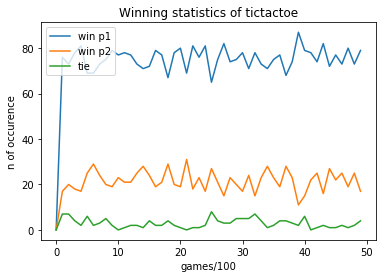

In [51]:
from matplotlib import pyplot as plt 

plt.plot(range(len(res_p1)), res_p1, label='win p1')
plt.plot(range(len(res_p2)), res_p2, label='win p2')
plt.plot(range(len(res_tie)), res_tie, label='tie')
plt.legend(loc="upper left")
plt.xlabel("games/100")
plt.ylabel("n of occurence")
plt.title("Winning statistics of tictactoe")

In [98]:
q_table1['states'][0]

array([[0., 0., 0.],
       [0., 0., 0.],
       [2., 1., 0.]])

In [130]:
q_table1['states'][15:20], q_table1['q_values'][15:20]

([array([[0., 2., 1.],
         [2., 2., 1.],
         [2., 1., 2.]]),
  array([[2., 1., 1.],
         [2., 2., 1.],
         [2., 1., 2.]]),
  array([[1., 0., 2.],
         [0., 0., 0.],
         [0., 0., 0.]]),
  array([[1., 0., 2.],
         [0., 0., 0.],
         [0., 0., 2.]]),
  array([[1., 2., 2.],
         [0., 0., 0.],
         [0., 0., 2.]])],
 [array([[ 0., nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]),
  array([[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]),
  array([[       nan, 0.0026663 ,        nan],
         [0.18716615, 0.08290443, 0.00263842],
         [0.18276668, 0.01329748, 0.17452111]]),
  array([[           nan, 3.43837811e-03,            nan],
         [1.46014275e-02, 0.00000000e+00, 2.54792059e-03],
         [1.51524377e-02, 3.22490000e-05,            nan]]),
  array([[       nan,        nan,        nan],
         [6.5341e-04, 0.0000e+00, 6.8590e-05],
         [8.5690e-04, 0.0000e+00,        nan]])])

In [ ]:
__states1 = np.concatenate(q_table1['states'], axis=1)
__q_values1 = np.concatenate(q_table1['q_values'], axis=1)
__final1 = np.concatenate((__states1, __q_values1), axis=0)
np.savetxt("player1.csv", __final1, delimiter=",")

__states2 = np.concatenate(q_table2['states'], axis=1)
__q_values2 = np.concatenate(q_table2['q_values'], axis=1)
__final2 = np.concatenate((__states2, __q_values2), axis=0)
np.savetxt("player2.csv", __final2, delimiter=",")

In [ ]:
%store results_count
results_count

In [ ]:
%store results
results

Stored 'results' (dict)


{'won_p1': 2344, 'won_p2': 2324, 'tie': 300}